In [1]:
import pandas as pd
import numpy as np
from warnings import simplefilter
simplefilter(action="ignore", category=Warning)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X, y = data.drop('Activity', axis=1), data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

 # <center>******Logistic Regression******   

In [4]:
log_reg = linear_model.LogisticRegression(max_iter=50)
%time log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 1.7 s
Wall time: 2.69 s
Значение f1-score на тренировочном наборе: 0.87
Значение f1-score на тестовом наборе: 0.79


 ### <center>**GridSearchCV**

In [5]:
param_grid = {'penalty': ['l2', 'none'] ,
                  'solver': ['lbfgs', 'saga'] 
                  }

In [6]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,
        max_iter=50
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения параметров: {}'.format(grid_search.best_params_))

CPU times: total: 5.97 s
Wall time: 1min 39s
Значение f1-score на тренировочном наборе: 0.86
Значение f1-score на тестовом наборе: 0.78
Наилучшие значения параметров: {'penalty': 'l2', 'solver': 'saga'}


результаты метрик практически не изменились, расширим сетку гиперпараметров

In [7]:
param_grid = [
              {'penalty': ['l2', 'none'] , 
              'solver': ['lbfgs', 'sag'], 
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, 
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}]

In [8]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,
        max_iter=50
    ), 
    param_grid=param_grid,
    cv=5, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшая модель:\n{}'.format(grid_search.best_estimator_))
print('Наилучшее значение точности при кросс-валидации: {:.2f}'.format(grid_search.best_score_))

CPU times: total: 3.61 s
Wall time: 6min 49s
Значение f1-score на тренировочном наборе: 0.85
Значение f1-score на тестовом наборе: 0.79
Наилучшая модель:
LogisticRegression(C=0.1, max_iter=50, random_state=42)
Наилучшее значение точности при кросс-валидации: 0.76


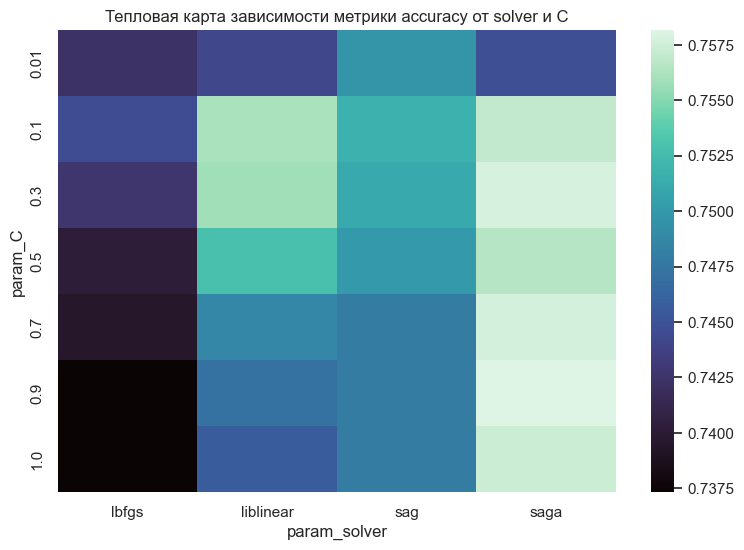

In [10]:
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
               values='mean_test_score', index='param_C',
               columns='param_solver')
sns.heatmap(visual, cmap = 'mako')
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') 
sns.set(rc={'figure.figsize':(10, 8)})

Результаты, полученные при построении тепловой карты, подтверждают показатели предыдущих  исследований: 
- Параметр С "стартует" с 0,1, поэтому ниже не стоит брать.
- Алгоритм оптимизации, который дал лучшие результаты - saga, на втором месте - liblinear.
- Оптимальный выбор: С=0,9 + saga. 

### <center> **RandomizedSearchCV**

In [11]:
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
 
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
y_train_pred = random_search.predict(X_train)


print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


CPU times: total: 4.58 s
Wall time: 1min 8s
Значение f1-score на тренировочном наборе: 0.85
Значение f1_score на тестовом наборе: 0.79


### <center> **Hyperopt**

In [12]:
space={'penalty':  hp.choice('penalty',{'l1', 'l2'}),
       'solver':  hp.choice('solver',{'liblinear', 'saga'}),
       'C': hp.choice('C', {0.01,0.02,0.03,0.04,0.05,0.07,0.09,1})     
       }

In [13]:
random_state = 42
def hyperopt_log_reg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'penalty': params['penalty'] ,
              'solver': params['solver'], 
               'C': params['C']}
  
    model = linear_model.LogisticRegression(**params, random_state=42, max_iter=50)

    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    return -score

In [14]:
%%time

trials = Trials() 

best=fmin(hyperopt_log_reg, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=15, 
          trials=trials, 
          rstate=np.random.default_rng(random_state)
         )
print('Наилучшие значения гиперпараметров {}'.format(best))

100%|██████████| 15/15 [03:45<00:00, 15.04s/trial, best loss: -0.7856870897253121]
Наилучшие значения гиперпараметров {'C': 4, 'penalty': 0, 'solver': 0}
CPU times: total: 1min 1s
Wall time: 3min 48s


In [15]:
model = linear_model.LogisticRegression(penalty='l2', solver='saga', random_state=42, max_iter=50)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Значение f1-score на тренировочном наборе: 0.86
Значение f1_score на тестовом наборе: 0.78


### <center> **Optuna**

In [16]:
def optuna_log_reg(trial):
  
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_float('C', 0.01, 1)
  
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=42,
                                          max_iter=50)

  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))
    
  return score

In [17]:
%%time

study = optuna.create_study(study_name='LogisticRegression', direction='maximize')
study.optimize(optuna_log_reg, n_trials=20)

model = linear_model.LogisticRegression(**study.best_params, random_state=42, max_iter=50)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

CPU times: total: 58.2 s
Wall time: 50.2 s


In [18]:
print('Значение f1-score на тренировочном наборе: {:.2f}'.format(study.best_value))
print('Значение f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Значение f1-score на тренировочном наборе: 0.88
Значение f1_score на тестовом наборе: 0.78


 # <center>******RandomForest******   

In [19]:
r_f = ensemble.RandomForestClassifier(random_state=42)
r_f.fit(X_train, y_train)

y_train_pred = r_f.predict(X_train)
y_test_pred = r_f.predict(X_test)

print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Значение f1-score на тренировочном наборе: 1.00
Значение f1_score на тестовом наборе: 0.81


 ### <center>**GridSearchCV**

In [20]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
y_test_pred = grid_search_forest.predict(X_test)

print('Значение f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_forest.best_params_))

CPU times: total: 4.5 s
Wall time: 2min 37s
Значение f1_score на тренировочном наборе: 0.94
Значение f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


### <center> **RandomizedSearchCV**

In [21]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
y_test_pred = random_search_forest.predict(X_test)

print('Значение f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search_forest.best_params_))

CPU times: total: 5.98 s
Wall time: 1min 34s
Значение f1_score на тренировочном наборе: 0.95
Значение f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 26}


### <center> **Hyperopt**

In [100]:
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [101]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    return -score

In [102]:
%%time

trials = Trials() 

best=fmin(hyperopt_rf, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          rstate=np.random.default_rng(random_state)
         )

print('Наилучшие значения гиперпараметров {}'.format(best))

100%|██████████| 20/20 [04:16<00:00, 12.81s/trial, best loss: -0.8080577050312506]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 1min 15s
Wall time: 4min 18s


In [103]:
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Значение f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Значение f1_score на тренировочном наборе: 0.99
Значение f1_score на тестовом наборе: 0.82


### <center> **Optuna**

In [104]:
def optuna_rf(trial):
  
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 15, 26, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  model.fit(X_train, y_train)
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()

  return score

In [105]:
%%time
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=20)

CPU times: total: 1min 19s
Wall time: 4min 30s


In [106]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [107]:
print('Значение f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров {}'.format(study.best_params))

Значение f1_score на тренировочном наборе: 0.99
Значение f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров {'n_estimators': 135, 'max_depth': 19, 'min_samples_leaf': 2}


Результаты применения методов оптимизации в данном задании незначительно отличаются друг от друга, что указывает на относительную взаимозаменяемость и результативность. При этом качественное отличие- временные затраты. На данный момент оптимальным кажется выбор в пользу RandomizedSearchCV и по полученным результатам, и по затраченному времени.
